In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets

from dbc.main import KmeansDiscreteBayesianClassifier, KmeansDiscreteMinimaxClassifier, \
    CmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier, DecisionTreeDiscreteMinimaxClassifier
from dbc.utils import compute_conditional_risk

In [2]:
# Generate data
X_train, y_train = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                       cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True, random_state=24)
X_train, y_train = datasets.make_blobs(n_samples=[125 * 5, 125 * 2], n_features=2, centers=[(9.5, 10), (10, 9.4)],
                                       cluster_std=[[0.6, 0.6], [0.35, 0.3]], shuffle=True, random_state=24)

In [3]:
# Initialize the Kmeans Discrete Bayesian Classifier with 10 clusters and a set random state for reproducibility
DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=15, random_state=25)

# Fit the classifier using the training data
DBC_kmeans.fit(X_train, y_train)

# Predict the labels for the training data
y_pred = DBC_kmeans.predict(X_train)

# Compute the conditional risk based on the true labels and predicted labels
conditional_risk = compute_conditional_risk(y_train, y_pred)
print(f'Class condition risk: \n{conditional_risk[0]}')
print(f'\nConfusion matrix: \n{conditional_risk[1]}')

Class condition risk: 
[0.1328 0.188 ]

Confusion matrix: 
[[0.8672 0.1328]
 [0.188  0.812 ]]


In [4]:
# Predict the probability distribution over classes for each sample in the training data
DBC_kmeans.predict_prob(X_train)

array([[0.97727273, 0.02272727],
       [0.97727273, 0.02272727],
       [0.97142857, 0.02857143],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.97142857, 0.02857143]], shape=(875, 2))

In [5]:
# Initialize the C-means Discrete Bayesian Classifier with 10 clusters
# Set the fuzzifier to 1.5 and use the cluster centers from the DBC_kmeans classifier
DBC_fcm = CmeansDiscreteBayesianClassifier(n_clusters=15, fuzzifier=1.5, cluster_centers=DBC_kmeans.cluster_centers, random_state=25)
# DBC_fcm = CmeansDiscreteBayesianClassifier(n_clusters=15, fuzzifier=1.5)

# Fit the classifier using the training data
DBC_fcm.fit(X_train, y_train)

# Predict the labels for the training data
y_pred = DBC_fcm.predict(X_train)

# Compute and return the conditional risk based on the true labels and predicted labels
conditional_risk = compute_conditional_risk(y_train, y_pred)
print(f'Class condition risk: \n{conditional_risk[0]}')
print(f'\nConfusion matrix: \n{conditional_risk[1]}')

Class condition risk: 
[0.1216 0.2   ]

Confusion matrix: 
[[0.8784 0.1216]
 [0.2    0.8   ]]


In [6]:
# Predict the probability distribution over classes for each sample in the training data
DBC_fcm.predict_prob(X_train)

array([[0.96605742, 0.03394258],
       [0.97035024, 0.02964976],
       [0.80770157, 0.19229843],
       ...,
       [0.99744862, 0.00255138],
       [0.99840602, 0.00159398],
       [0.78865253, 0.21134747]], shape=(875, 2))

Text(0.5, 1.0, 'PDBC with soft clustering')

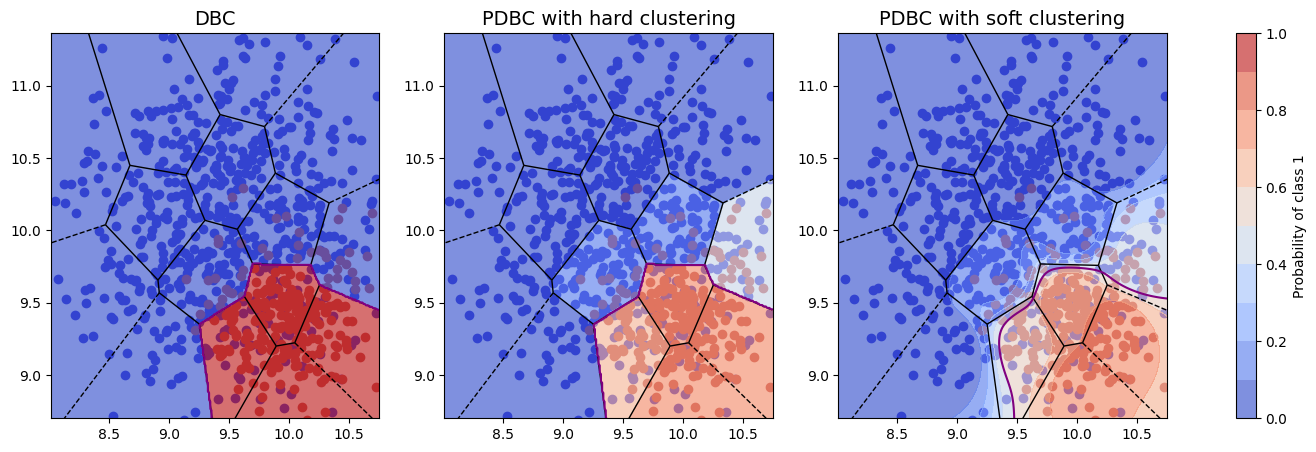

In [6]:
# Plot decision boundaries and probability contours for DBC, PDBC with hard clustering, and PDBC with soft clustering

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DBC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DBC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2[:, 1].reshape(xx.shape)

class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5

boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DBC', fontsize=14)
ax[1].set_title('PDBC with hard clustering', fontsize=14)
ax[2].set_title('PDBC with soft clustering', fontsize=14)

In [8]:
DMC_kmeans = KmeansDiscreteMinimaxClassifier(n_clusters=15, random_state=25)
DMC_kmeans.fit(X_train, y_train)
y_pred = DMC_kmeans.predict(X_train)
conditional_risk = compute_conditional_risk(y_train, y_pred)
print(f'Class condition risk: \n{conditional_risk[0]}')
print(f'\nConfusion matrix: \n{conditional_risk[1]}')

Class condition risk: 
[0.1776 0.108 ]

Confusion matrix: 
[[0.8224 0.1776]
 [0.108  0.892 ]]


Text(0.5, 1.0, 'PDMC with soft clustering')

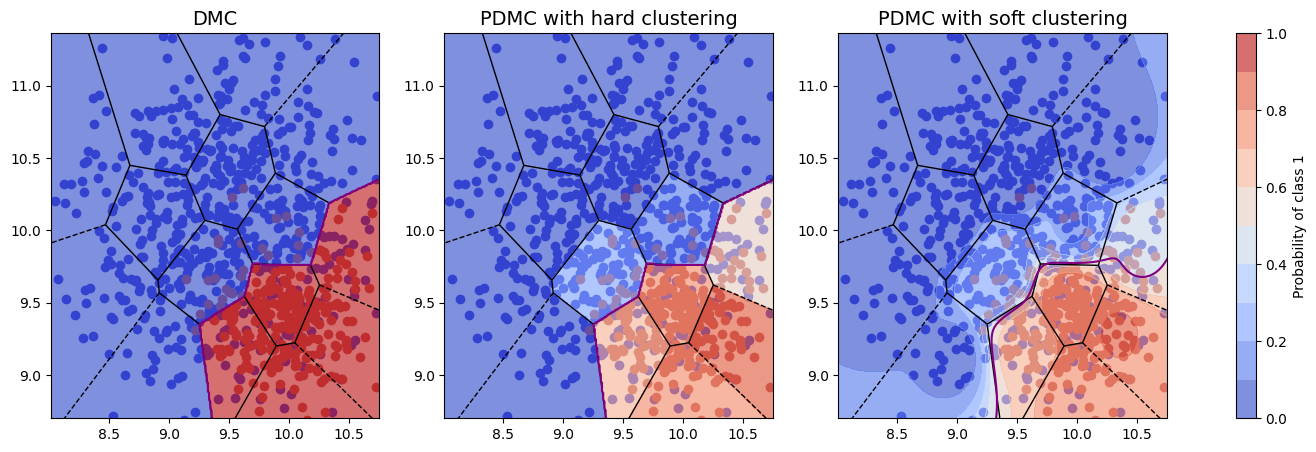

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

vor = Voronoi(DMC_kmeans.cluster_centers)
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[0])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[1])
voronoi_plot_2d(vor, show_points=False, show_vertices=False, s=1, ax=ax[2])

Z1 = DMC_kmeans.predict_prob(np.c_[xx.ravel(), yy.ravel()])

Z0 = np.zeros_like(Z1)

max_indices = np.argmax(Z1, axis=1)

rows = np.arange(Z1.shape[0])

Z0[rows, max_indices] = 1.0

Z1 = Z1[:, 1].reshape(xx.shape)
Z0 = Z0[:, 1].reshape(xx.shape)

Z2 = DBC_fcm.predict_prob(np.c_[xx.ravel(), yy.ravel()], prior_pred=DMC_kmeans.prior_star)
Z2 = Z2[:, 1].reshape(xx.shape)

class0_indices = (y_train == 0)
class1_indices = (y_train == 1)
for i in range(3):
    ax[i].scatter(X_train[class0_indices, 0], X_train[class0_indices, 1], color='mediumblue')
    ax[i].scatter(X_train[class1_indices, 0], X_train[class1_indices, 1], color='firebrick')

contour0 = ax[0].contourf(xx, yy, Z0, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour1 = ax[1].contourf(xx, yy, Z1, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))
contour2 = ax[2].contourf(xx, yy, Z2, alpha=0.7, cmap='coolwarm', levels=np.linspace(0, 1, 11))

decision_boundary_prob = 0.5

boundary0 = ax[0].contour(xx, yy, Z0, levels=[decision_boundary_prob], colors='purple')
boundary1 = ax[1].contour(xx, yy, Z1, levels=[decision_boundary_prob], colors='purple')
boundary2 = ax[2].contour(xx, yy, Z2, levels=[decision_boundary_prob], colors='purple')

cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
cbar.set_label('Probability of class 1')

ax[0].set_title('DMC', fontsize=14)
ax[1].set_title('PDMC with hard clustering', fontsize=14)
ax[2].set_title('PDMC with soft clustering', fontsize=14)

In [10]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=10)
DBC_DT.fit(X_train, y_train)
y_pred = DBC_DT.predict(X_train, prior_pred=DBC_DT.prior)
conditional_risk = compute_conditional_risk(y_train, y_pred)
print(f'Class condition risk: \n{conditional_risk[0]}')
print(f'\nConfusion matrix: \n{conditional_risk[1]}')

Class condition risk: 
[0.0672 0.016 ]

Confusion matrix: 
[[0.9328 0.0672]
 [0.016  0.984 ]]


In [11]:
DBC_DT.predict_prob(X_train)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(875, 2))

In [12]:
DMC_DT = DecisionTreeDiscreteMinimaxClassifier(max_depth=10)
DMC_DT.fit(X_train, y_train)
y_pred = DMC_DT.predict(X_train)
conditional_risk = compute_conditional_risk(y_train, y_pred)
print(f'Class condition risk: \n{conditional_risk[0]}')
print(f'\nConfusion matrix: \n{conditional_risk[1]}')

Class condition risk: 
[0.056 0.072]

Confusion matrix: 
[[0.944 0.056]
 [0.072 0.928]]
